In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from loguru import logger

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.sparse as sparse
import torch.optim as optim

import pandas as pd
import plotly.express as px

sys.path.insert(0, '..')

from src.viz import blueq_colors

# Implement

In [3]:
from src.train_utils import mse_loss, train, MetricLogCallback
from src.model import LightGCN

In [4]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = 'cpu'
logger.info(f"Using {device} device")

2024-09-09 20:59:16.445 | INFO     | __main__:<module>:9 - Using cpu device


# Test implementation

In [5]:
# Mock data
user_ids = [0, 0, 1, 2, 2]
item_ids = [0, 1, 2, 3, 1]
ratings = [1, 4, 5, 3, 2]
n_users = len(set(user_ids))
n_items = len(set(item_ids))

val_user_ids = [0, 1, 2]
val_item_ids = [2, 1, 2]
val_ratings = [2, 4, 5]

print("Mock User IDs:", user_ids)
print("Mock Item IDs:", item_ids)
print("Ratings:", ratings)

embedding_dim = 8
n_layers = 3

model = LightGCN(embedding_dim, n_layers, user_ids=user_ids, item_ids=item_ids, ratings=ratings, device=device)

# Example forward pass
users = torch.tensor([0, 1, 2])
items = torch.tensor([0, 1, 2])
predictions = model.predict(users, items)
print(predictions)

Mock User IDs: [0, 0, 1, 2, 2]
Mock Item IDs: [0, 1, 2, 3, 1]
Ratings: [1, 4, 5, 3, 2]
tensor([0.0024, 0.0013, 0.0020], grad_fn=<SumBackward1>)


In [6]:
import random
import numpy as np
from torch.utils.data import DataLoader
from src.dataset_loader import UserItemRatingDataset

batch_size = 4

rating_dataset = UserItemRatingDataset(user_ids, item_ids, ratings)
dataloader = DataLoader(rating_dataset, batch_size=batch_size, shuffle=True)

val_rating_dataset = UserItemRatingDataset(val_user_ids, val_item_ids, val_ratings)
val_dataloader = DataLoader(val_rating_dataset, batch_size=batch_size, shuffle=True)

# Instantiate LightGCN model
model = LightGCN(embedding_dim=embedding_dim, n_layers=n_layers,
                 user_ids=user_ids, item_ids=item_ids, ratings=ratings, device=device)

# Training loop
n_epochs = 50

train(model, dataloader, val_dataloader, epochs=n_epochs, patience=2, print_steps=1, lr=0.001, device=device, progress_bar_type='tqdm_notebook')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-09 20:59:16.938 | INFO     | src.train_utils:train:122 - Step 1, Global Loss: 11.5078
2024-09-09 20:59:16.939 | INFO     | src.train_utils:train:125 - Step 1, Learning Rate: 0.001000
2024-09-09 20:59:16.940 | INFO     | src.train_utils:train:128 - Step 1, Gradient Norms: {'grad_norm_user_embedding.weight': 0.047441765666007996, 'grad_norm_item_embedding.weight': 0.06825494766235352, 'total_grad_norm': 0.08312315567818052}
2024-09-09 20:59:16.941 | INFO     | src.train_utils:train:122 - Step 2, Global Loss: 10.2516
2024-09-09 20:59:16.942 | INFO     | src.train_utils:train:125 - Step 2, Learning Rate: 0.001000
2024-09-09 20:59:16.942 | INFO     | src.train_utils:train:128 - Step 2, Gradient Norms: {'grad_norm_user_embedding.weight': 0.06820892542600632, 'grad_norm_item_embedding.weight': 0.10335502028465271, 'total_grad_norm': 0.12383342733612546}
2024-09-09 20:59:16.943 | INFO     | src.train_utils:train:140 - Epoch 1, Loss: 10.2516
2024-09-09 20:59:16.944 | INFO     | src.trai

Training Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-09 20:59:16.949 | INFO     | src.train_utils:train:122 - Step 3, Global Loss: 9.7585
2024-09-09 20:59:16.949 | INFO     | src.train_utils:train:125 - Step 3, Learning Rate: 0.001000
2024-09-09 20:59:16.949 | INFO     | src.train_utils:train:128 - Step 3, Gradient Norms: {'grad_norm_user_embedding.weight': 0.04396060109138489, 'grad_norm_item_embedding.weight': 0.06683593988418579, 'total_grad_norm': 0.07999735813461821}
2024-09-09 20:59:16.950 | INFO     | src.train_utils:train:122 - Step 4, Global Loss: 12.8738
2024-09-09 20:59:16.951 | INFO     | src.train_utils:train:125 - Step 4, Learning Rate: 0.001000
2024-09-09 20:59:16.951 | INFO     | src.train_utils:train:128 - Step 4, Gradient Norms: {'grad_norm_user_embedding.weight': 0.0958259105682373, 'grad_norm_item_embedding.weight': 0.12662453949451447, 'total_grad_norm': 0.15879665972063037}
2024-09-09 20:59:16.951 | INFO     | src.train_utils:train:140 - Epoch 2, Loss: 12.8738
2024-09-09 20:59:16.952 | INFO     | src.train_u

Training Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09-09 20:59:16.957 | INFO     | src.train_utils:train:122 - Step 5, Global Loss: 9.7579
2024-09-09 20:59:16.957 | INFO     | src.train_utils:train:125 - Step 5, Learning Rate: 0.001000
2024-09-09 20:59:16.957 | INFO     | src.train_utils:train:128 - Step 5, Gradient Norms: {'grad_norm_user_embedding.weight': 0.04370412230491638, 'grad_norm_item_embedding.weight': 0.06644149869680405, 'total_grad_norm': 0.07952687002215354}
2024-09-09 20:59:16.958 | INFO     | src.train_utils:train:122 - Step 6, Global Loss: 12.8732
2024-09-09 20:59:16.959 | INFO     | src.train_utils:train:125 - Step 6, Learning Rate: 0.001000
2024-09-09 20:59:16.959 | INFO     | src.train_utils:train:128 - Step 6, Gradient Norms: {'grad_norm_user_embedding.weight': 0.09666074812412262, 'grad_norm_item_embedding.weight': 0.12690867483615875, 'total_grad_norm': 0.1595277780719864}
2024-09-09 20:59:16.959 | INFO     | src.train_utils:train:140 - Epoch 3, Loss: 12.8732
2024-09-09 20:59:16.960 | INFO     | src.train_u

# Prep data

In [7]:
train_df = pd.read_parquet("../data/train.parquet")
val_df = pd.read_parquet("../data/val.parquet")

In [8]:
from src.id_mapper import IDMapper

In [9]:
user_ids = train_df['user_id'].values
item_ids = train_df['parent_asin'].values
unique_user_ids = list(set(user_ids))
unique_item_ids = list(set(item_ids))

logger.info(f"{len(unique_user_ids)=:,.0f}, {len(unique_item_ids)=:,.0f}")

2024-09-09 20:59:17.039 | INFO     | __main__:<module>:6 - len(unique_user_ids)=5,223, len(unique_item_ids)=2,653


In [10]:
idm = IDMapper()
idm.fit(unique_user_ids, unique_item_ids)

In [11]:
user_indices = [idm.get_user_index(user_id) for user_id in user_ids]
item_indices = [idm.get_item_index(item_id) for item_id in item_ids]
ratings = train_df['rating'].values.tolist()

In [12]:
val_user_indices = [idm.get_user_index(user_id) for user_id in val_df['user_id']]
val_item_indices = [idm.get_item_index(item_id) for item_id in val_df['parent_asin']]
val_ratings = val_df['rating'].values.tolist()

# Train

In [13]:
batch_size = 128

rating_dataset = UserItemRatingDataset(user_indices, item_indices, ratings)
dataloader = DataLoader(rating_dataset, batch_size=batch_size, shuffle=True)

val_rating_dataset = UserItemRatingDataset(val_user_indices, val_item_indices, val_ratings)
val_dataloader = DataLoader(val_rating_dataset, batch_size=batch_size, shuffle=True)

In [14]:
embedding_dim = 128
n_layers = 3

# Instantiate LightGCN model
model = LightGCN(embedding_dim=embedding_dim, n_layers=n_layers,
                 user_ids=user_indices, item_ids=item_indices, ratings=ratings, device=device)

#### Predict before train

In [15]:
user_id = 'AEHW2B54HDLZ3APBEWXHYLZ6SSYQ'
val_df.loc[lambda df: df['user_id'].eq(user_id)]

,user_id,parent_asin,rating,timestamp
34367,AEHW2B54HDLZ3APBEWXHYLZ6SSYQ,B07MYVF61Y,4.0,1654225907045


In [16]:
item_id = 'B07MYVF61Y'
user_indice = idm.get_user_index(user_id)
item_indice = idm.get_item_index(item_id)

model.predict([user_indice], [item_indice])

tensor([0.0039], grad_fn=<SumBackward1>)

#### Training loop

In [17]:
n_epochs = 50

metric_log_cb = MetricLogCallback()

train(
    model,
    dataloader,
    val_dataloader,
    epochs=n_epochs,
    patience=2,
    print_steps=100,
    lr=0.03,
    device=device,
    progress_bar_type='tqdm_notebook',
    callbacks=[metric_log_cb.process_payload]
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:19.173 | INFO     | src.train_utils:train:122 - Step 100, Global Loss: 19.4098
2024-09-09 20:59:19.173 | INFO     | src.train_utils:train:125 - Step 100, Learning Rate: 0.030000
2024-09-09 20:59:19.174 | INFO     | src.train_utils:train:128 - Step 100, Gradient Norms: {'grad_norm_user_embedding.weight': 0.16525961458683014, 'grad_norm_item_embedding.weight': 0.13665802776813507, 'total_grad_norm': 0.21444383126325647}
2024-09-09 20:59:19.985 | INFO     | src.train_utils:train:140 - Epoch 1, Loss: 18.8766
2024-09-09 20:59:20.218 | INFO     | src.train_utils:train:155 - Epoch 1, Validation Loss: 18.3964


Training Epoch 2:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:21.298 | INFO     | src.train_utils:train:122 - Step 200, Global Loss: 10.6567
2024-09-09 20:59:21.299 | INFO     | src.train_utils:train:125 - Step 200, Learning Rate: 0.030000
2024-09-09 20:59:21.299 | INFO     | src.train_utils:train:128 - Step 200, Gradient Norms: {'grad_norm_user_embedding.weight': 0.2473791092634201, 'grad_norm_item_embedding.weight': 0.1633397936820984, 'total_grad_norm': 0.2964393899266317}
2024-09-09 20:59:22.810 | INFO     | src.train_utils:train:140 - Epoch 2, Loss: 8.4190
2024-09-09 20:59:23.033 | INFO     | src.train_utils:train:155 - Epoch 2, Validation Loss: 14.0303


Training Epoch 3:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:23.330 | INFO     | src.train_utils:train:122 - Step 300, Global Loss: 1.9158
2024-09-09 20:59:23.331 | INFO     | src.train_utils:train:125 - Step 300, Learning Rate: 0.030000
2024-09-09 20:59:23.331 | INFO     | src.train_utils:train:128 - Step 300, Gradient Norms: {'grad_norm_user_embedding.weight': 0.13918320834636688, 'grad_norm_item_embedding.weight': 0.09447640180587769, 'total_grad_norm': 0.1682193686344525}
2024-09-09 20:59:25.139 | INFO     | src.train_utils:train:122 - Step 400, Global Loss: 2.0006
2024-09-09 20:59:25.140 | INFO     | src.train_utils:train:125 - Step 400, Learning Rate: 0.030000
2024-09-09 20:59:25.140 | INFO     | src.train_utils:train:128 - Step 400, Gradient Norms: {'grad_norm_user_embedding.weight': 0.12940366566181183, 'grad_norm_item_embedding.weight': 0.0964478999376297, 'total_grad_norm': 0.16139239786648257}
2024-09-09 20:59:25.602 | INFO     | src.train_utils:train:140 - Epoch 3, Loss: 2.0124
2024-09-09 20:59:25.831 | INFO     | sr

Training Epoch 4:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:27.171 | INFO     | src.train_utils:train:122 - Step 500, Global Loss: 0.7264
2024-09-09 20:59:27.171 | INFO     | src.train_utils:train:125 - Step 500, Learning Rate: 0.030000
2024-09-09 20:59:27.172 | INFO     | src.train_utils:train:128 - Step 500, Gradient Norms: {'grad_norm_user_embedding.weight': 0.08838517963886261, 'grad_norm_item_embedding.weight': 0.06677688658237457, 'total_grad_norm': 0.1107749636038276}
2024-09-09 20:59:28.361 | INFO     | src.train_utils:train:140 - Epoch 4, Loss: 0.8318
2024-09-09 20:59:28.586 | INFO     | src.train_utils:train:155 - Epoch 4, Validation Loss: 12.8120


Training Epoch 5:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:29.160 | INFO     | src.train_utils:train:122 - Step 600, Global Loss: 0.4867
2024-09-09 20:59:29.161 | INFO     | src.train_utils:train:125 - Step 600, Learning Rate: 0.030000
2024-09-09 20:59:29.161 | INFO     | src.train_utils:train:128 - Step 600, Gradient Norms: {'grad_norm_user_embedding.weight': 0.07185768336057663, 'grad_norm_item_embedding.weight': 0.04856908693909645, 'total_grad_norm': 0.0867322481205601}
2024-09-09 20:59:30.939 | INFO     | src.train_utils:train:122 - Step 700, Global Loss: 0.6350
2024-09-09 20:59:30.940 | INFO     | src.train_utils:train:125 - Step 700, Learning Rate: 0.030000
2024-09-09 20:59:30.940 | INFO     | src.train_utils:train:128 - Step 700, Gradient Norms: {'grad_norm_user_embedding.weight': 0.08785729855298996, 'grad_norm_item_embedding.weight': 0.06277161836624146, 'total_grad_norm': 0.10797768742358892}
2024-09-09 20:59:31.144 | INFO     | src.train_utils:train:140 - Epoch 5, Loss: 0.6443
2024-09-09 20:59:31.406 | INFO     | s

Training Epoch 6:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:33.226 | INFO     | src.train_utils:train:122 - Step 800, Global Loss: 0.5571
2024-09-09 20:59:33.226 | INFO     | src.train_utils:train:125 - Step 800, Learning Rate: 0.030000
2024-09-09 20:59:33.227 | INFO     | src.train_utils:train:128 - Step 800, Gradient Norms: {'grad_norm_user_embedding.weight': 0.09460223466157913, 'grad_norm_item_embedding.weight': 0.05757569149136543, 'total_grad_norm': 0.11074539743787719}
2024-09-09 20:59:34.311 | INFO     | src.train_utils:train:140 - Epoch 6, Loss: 0.6391
2024-09-09 20:59:34.577 | INFO     | src.train_utils:train:155 - Epoch 6, Validation Loss: 12.5399


Training Epoch 7:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:35.583 | INFO     | src.train_utils:train:122 - Step 900, Global Loss: 0.5530
2024-09-09 20:59:35.583 | INFO     | src.train_utils:train:125 - Step 900, Learning Rate: 0.030000
2024-09-09 20:59:35.583 | INFO     | src.train_utils:train:128 - Step 900, Gradient Norms: {'grad_norm_user_embedding.weight': 0.0920262262225151, 'grad_norm_item_embedding.weight': 0.056313663721084595, 'total_grad_norm': 0.10788908672543727}
2024-09-09 20:59:37.369 | INFO     | src.train_utils:train:140 - Epoch 7, Loss: 0.6874
2024-09-09 20:59:37.596 | INFO     | src.train_utils:train:155 - Epoch 7, Validation Loss: 12.4476


Training Epoch 8:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:37.704 | INFO     | src.train_utils:train:122 - Step 1000, Global Loss: 0.5049
2024-09-09 20:59:37.705 | INFO     | src.train_utils:train:125 - Step 1000, Learning Rate: 0.027000
2024-09-09 20:59:37.705 | INFO     | src.train_utils:train:128 - Step 1000, Gradient Norms: {'grad_norm_user_embedding.weight': 0.08889123797416687, 'grad_norm_item_embedding.weight': 0.05595655366778374, 'total_grad_norm': 0.10503707958123897}
2024-09-09 20:59:39.626 | INFO     | src.train_utils:train:122 - Step 1100, Global Loss: 0.6550
2024-09-09 20:59:39.627 | INFO     | src.train_utils:train:125 - Step 1100, Learning Rate: 0.027000
2024-09-09 20:59:39.627 | INFO     | src.train_utils:train:128 - Step 1100, Gradient Norms: {'grad_norm_user_embedding.weight': 0.08360353112220764, 'grad_norm_item_embedding.weight': 0.057589925825595856, 'total_grad_norm': 0.10151920987034707}
2024-09-09 20:59:40.344 | INFO     | src.train_utils:train:140 - Epoch 8, Loss: 0.6841
2024-09-09 20:59:40.613 | INFO

Training Epoch 9:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:41.887 | INFO     | src.train_utils:train:122 - Step 1200, Global Loss: 0.5747
2024-09-09 20:59:41.888 | INFO     | src.train_utils:train:125 - Step 1200, Learning Rate: 0.027000
2024-09-09 20:59:41.888 | INFO     | src.train_utils:train:128 - Step 1200, Gradient Norms: {'grad_norm_user_embedding.weight': 0.07827209681272507, 'grad_norm_item_embedding.weight': 0.05440124496817589, 'total_grad_norm': 0.09532059899910453}
2024-09-09 20:59:43.467 | INFO     | src.train_utils:train:140 - Epoch 9, Loss: 0.6697
2024-09-09 20:59:43.734 | INFO     | src.train_utils:train:155 - Epoch 9, Validation Loss: 12.0829


Training Epoch 10:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:44.199 | INFO     | src.train_utils:train:122 - Step 1300, Global Loss: 0.4864
2024-09-09 20:59:44.199 | INFO     | src.train_utils:train:125 - Step 1300, Learning Rate: 0.027000
2024-09-09 20:59:44.200 | INFO     | src.train_utils:train:128 - Step 1300, Gradient Norms: {'grad_norm_user_embedding.weight': 0.07746157795190811, 'grad_norm_item_embedding.weight': 0.0528535358607769, 'total_grad_norm': 0.09377522226998967}
2024-09-09 20:59:46.078 | INFO     | src.train_utils:train:122 - Step 1400, Global Loss: 0.6355
2024-09-09 20:59:46.079 | INFO     | src.train_utils:train:125 - Step 1400, Learning Rate: 0.027000
2024-09-09 20:59:46.079 | INFO     | src.train_utils:train:128 - Step 1400, Gradient Norms: {'grad_norm_user_embedding.weight': 0.10124446451663971, 'grad_norm_item_embedding.weight': 0.06865793466567993, 'total_grad_norm': 0.12232887471001232}
2024-09-09 20:59:46.440 | INFO     | src.train_utils:train:140 - Epoch 10, Loss: 0.6636
2024-09-09 20:59:46.671 | INFO 

Training Epoch 11:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:48.085 | INFO     | src.train_utils:train:122 - Step 1500, Global Loss: 0.6266
2024-09-09 20:59:48.086 | INFO     | src.train_utils:train:125 - Step 1500, Learning Rate: 0.027000
2024-09-09 20:59:48.086 | INFO     | src.train_utils:train:128 - Step 1500, Gradient Norms: {'grad_norm_user_embedding.weight': 0.099939726293087, 'grad_norm_item_embedding.weight': 0.06458272784948349, 'total_grad_norm': 0.11899108213650969}
2024-09-09 20:59:49.174 | INFO     | src.train_utils:train:140 - Epoch 11, Loss: 0.7110
2024-09-09 20:59:49.404 | INFO     | src.train_utils:train:155 - Epoch 11, Validation Loss: 11.9006


Training Epoch 12:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:50.128 | INFO     | src.train_utils:train:122 - Step 1600, Global Loss: 0.6192
2024-09-09 20:59:50.128 | INFO     | src.train_utils:train:125 - Step 1600, Learning Rate: 0.027000
2024-09-09 20:59:50.128 | INFO     | src.train_utils:train:128 - Step 1600, Gradient Norms: {'grad_norm_user_embedding.weight': 0.07758144289255142, 'grad_norm_item_embedding.weight': 0.057470496743917465, 'total_grad_norm': 0.09654914954199673}
2024-09-09 20:59:52.061 | INFO     | src.train_utils:train:122 - Step 1700, Global Loss: 0.7196
2024-09-09 20:59:52.062 | INFO     | src.train_utils:train:125 - Step 1700, Learning Rate: 0.027000
2024-09-09 20:59:52.062 | INFO     | src.train_utils:train:128 - Step 1700, Gradient Norms: {'grad_norm_user_embedding.weight': 0.1141427531838417, 'grad_norm_item_embedding.weight': 0.0774625837802887, 'total_grad_norm': 0.13794571392510044}
2024-09-09 20:59:52.140 | INFO     | src.train_utils:train:140 - Epoch 12, Loss: 0.7238
2024-09-09 20:59:52.402 | INFO 

Training Epoch 13:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:54.274 | INFO     | src.train_utils:train:122 - Step 1800, Global Loss: 0.7207
2024-09-09 20:59:54.275 | INFO     | src.train_utils:train:125 - Step 1800, Learning Rate: 0.027000
2024-09-09 20:59:54.275 | INFO     | src.train_utils:train:128 - Step 1800, Gradient Norms: {'grad_norm_user_embedding.weight': 0.08799770474433899, 'grad_norm_item_embedding.weight': 0.0638170838356018, 'total_grad_norm': 0.10870242053216704}
2024-09-09 20:59:55.192 | INFO     | src.train_utils:train:140 - Epoch 13, Loss: 0.7644
2024-09-09 20:59:55.435 | INFO     | src.train_utils:train:155 - Epoch 13, Validation Loss: 11.7038


Training Epoch 14:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:56.501 | INFO     | src.train_utils:train:122 - Step 1900, Global Loss: 0.6617
2024-09-09 20:59:56.502 | INFO     | src.train_utils:train:125 - Step 1900, Learning Rate: 0.027000
2024-09-09 20:59:56.502 | INFO     | src.train_utils:train:128 - Step 1900, Gradient Norms: {'grad_norm_user_embedding.weight': 0.10184555500745773, 'grad_norm_item_embedding.weight': 0.06772403419017792, 'total_grad_norm': 0.122307243782899}
2024-09-09 20:59:58.226 | INFO     | src.train_utils:train:140 - Epoch 14, Loss: 0.7846
2024-09-09 20:59:58.486 | INFO     | src.train_utils:train:155 - Epoch 14, Validation Loss: 11.5794


Training Epoch 15:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 20:59:58.727 | INFO     | src.train_utils:train:122 - Step 2000, Global Loss: 0.6481
2024-09-09 20:59:58.727 | INFO     | src.train_utils:train:125 - Step 2000, Learning Rate: 0.024300
2024-09-09 20:59:58.728 | INFO     | src.train_utils:train:128 - Step 2000, Gradient Norms: {'grad_norm_user_embedding.weight': 0.09149591624736786, 'grad_norm_item_embedding.weight': 0.06459169089794159, 'total_grad_norm': 0.11199816615909648}
2024-09-09 21:00:00.685 | INFO     | src.train_utils:train:122 - Step 2100, Global Loss: 0.7056
2024-09-09 21:00:00.685 | INFO     | src.train_utils:train:125 - Step 2100, Learning Rate: 0.024300
2024-09-09 21:00:00.686 | INFO     | src.train_utils:train:128 - Step 2100, Gradient Norms: {'grad_norm_user_embedding.weight': 0.10477568954229355, 'grad_norm_item_embedding.weight': 0.06878350675106049, 'total_grad_norm': 0.1253360120637172}
2024-09-09 21:00:01.279 | INFO     | src.train_utils:train:140 - Epoch 15, Loss: 0.7308
2024-09-09 21:00:01.540 | INFO 

Training Epoch 16:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 21:00:02.904 | INFO     | src.train_utils:train:122 - Step 2200, Global Loss: 0.5799
2024-09-09 21:00:02.905 | INFO     | src.train_utils:train:125 - Step 2200, Learning Rate: 0.024300
2024-09-09 21:00:02.905 | INFO     | src.train_utils:train:128 - Step 2200, Gradient Norms: {'grad_norm_user_embedding.weight': 0.08362556993961334, 'grad_norm_item_embedding.weight': 0.05534067377448082, 'total_grad_norm': 0.10027874212184092}
2024-09-09 21:00:04.247 | INFO     | src.train_utils:train:140 - Epoch 16, Loss: 0.6612
2024-09-09 21:00:04.478 | INFO     | src.train_utils:train:155 - Epoch 16, Validation Loss: 11.2999


Training Epoch 17:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 21:00:05.169 | INFO     | src.train_utils:train:122 - Step 2300, Global Loss: 0.4718
2024-09-09 21:00:05.169 | INFO     | src.train_utils:train:125 - Step 2300, Learning Rate: 0.024300
2024-09-09 21:00:05.170 | INFO     | src.train_utils:train:128 - Step 2300, Gradient Norms: {'grad_norm_user_embedding.weight': 0.08023171126842499, 'grad_norm_item_embedding.weight': 0.05273369699716568, 'total_grad_norm': 0.0960102613893369}
2024-09-09 21:00:07.391 | INFO     | src.train_utils:train:122 - Step 2400, Global Loss: 0.6076
2024-09-09 21:00:07.391 | INFO     | src.train_utils:train:125 - Step 2400, Learning Rate: 0.024300
2024-09-09 21:00:07.392 | INFO     | src.train_utils:train:128 - Step 2400, Gradient Norms: {'grad_norm_user_embedding.weight': 0.09518574178218842, 'grad_norm_item_embedding.weight': 0.0666070431470871, 'total_grad_norm': 0.11617583068531669}
2024-09-09 21:00:07.706 | INFO     | src.train_utils:train:140 - Epoch 17, Loss: 0.6303
2024-09-09 21:00:08.101 | INFO  

Training Epoch 18:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 21:00:10.225 | INFO     | src.train_utils:train:122 - Step 2500, Global Loss: 0.5713
2024-09-09 21:00:10.226 | INFO     | src.train_utils:train:125 - Step 2500, Learning Rate: 0.024300
2024-09-09 21:00:10.226 | INFO     | src.train_utils:train:128 - Step 2500, Gradient Norms: {'grad_norm_user_embedding.weight': 0.09645969420671463, 'grad_norm_item_embedding.weight': 0.06535174697637558, 'total_grad_norm': 0.1165131899800066}
2024-09-09 21:00:11.612 | INFO     | src.train_utils:train:140 - Epoch 18, Loss: 0.6339
2024-09-09 21:00:11.841 | INFO     | src.train_utils:train:155 - Epoch 18, Validation Loss: 11.1668


Training Epoch 19:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 21:00:12.959 | INFO     | src.train_utils:train:122 - Step 2600, Global Loss: 0.5143
2024-09-09 21:00:12.960 | INFO     | src.train_utils:train:125 - Step 2600, Learning Rate: 0.024300
2024-09-09 21:00:12.960 | INFO     | src.train_utils:train:128 - Step 2600, Gradient Norms: {'grad_norm_user_embedding.weight': 0.0792432427406311, 'grad_norm_item_embedding.weight': 0.05460306257009506, 'total_grad_norm': 0.09623401665775101}
2024-09-09 21:00:15.504 | INFO     | src.train_utils:train:140 - Epoch 19, Loss: 0.6463
2024-09-09 21:00:15.968 | INFO     | src.train_utils:train:155 - Epoch 19, Validation Loss: 11.2214


Training Epoch 20:   0%|          | 0/142 [00:00<?, ?it/s]

2024-09-09 21:00:16.020 | INFO     | src.train_utils:train:122 - Step 2700, Global Loss: 0.4171
2024-09-09 21:00:16.021 | INFO     | src.train_utils:train:125 - Step 2700, Learning Rate: 0.024300
2024-09-09 21:00:16.021 | INFO     | src.train_utils:train:128 - Step 2700, Gradient Norms: {'grad_norm_user_embedding.weight': 0.07195418328046799, 'grad_norm_item_embedding.weight': 0.047915875911712646, 'total_grad_norm': 0.08644845664293738}
2024-09-09 21:00:18.509 | INFO     | src.train_utils:train:122 - Step 2800, Global Loss: 0.6055
2024-09-09 21:00:18.510 | INFO     | src.train_utils:train:125 - Step 2800, Learning Rate: 0.024300
2024-09-09 21:00:18.510 | INFO     | src.train_utils:train:128 - Step 2800, Gradient Norms: {'grad_norm_user_embedding.weight': 0.08508554846048355, 'grad_norm_item_embedding.weight': 0.0642080083489418, 'total_grad_norm': 0.10659370944365842}
2024-09-09 21:00:19.447 | INFO     | src.train_utils:train:140 - Epoch 20, Loss: 0.6563
2024-09-09 21:00:19.914 | INFO

# Visualize training

In [18]:
step_metrics = [p for p in metric_log_cb.payloads if 'step' in p]
epoch_metrics = [p for p in metric_log_cb.payloads if 'epoch' in p]
step_metrics_df = pd.DataFrame(step_metrics)
step_metrics_df

,step,dataset,global_loss,learning_rate,grad_norm_user_embedding.weight,grad_norm_item_embedding.weight,total_grad_norm
0,100,train,19.409774,0.0300,0.165260,0.136658,0.214444
1,200,train,10.656744,0.0300,0.247379,0.163340,0.296439
2,300,train,1.915833,0.0300,0.139183,0.094476,0.168219
3,400,train,2.000585,0.0300,0.129404,0.096448,0.161392
4,500,train,0.726389,0.0300,0.088385,0.066777,0.110775
5,600,train,0.486694,0.0300,0.071858,0.048569,0.086732
6,700,train,0.634995,0.0300,0.087857,0.062772,0.107978
7,800,train,0.557072,0.0300,0.094602,0.057576,0.110745
8,900,train,0.552970,0.0300,0.092026,0.056314,0.107889
9,1000,train,0.504941,0.0270,0.088891,0.055957,0.105037


In [19]:
epoch_metrics_df = pd.DataFrame(epoch_metrics)
epoch_metrics_df = epoch_metrics_df.pipe(lambda df: pd.melt(df, id_vars=["epoch"], var_name="loss_type", value_name="value"))
epoch_metrics_df

,epoch,loss_type,value
0,1,train_loss,18.876572
1,2,train_loss,8.419007
2,3,train_loss,2.012403
3,4,train_loss,0.831765
4,5,train_loss,0.644330
5,6,train_loss,0.639061
6,7,train_loss,0.687383
7,8,train_loss,0.684100
8,9,train_loss,0.669744
9,10,train_loss,0.663608


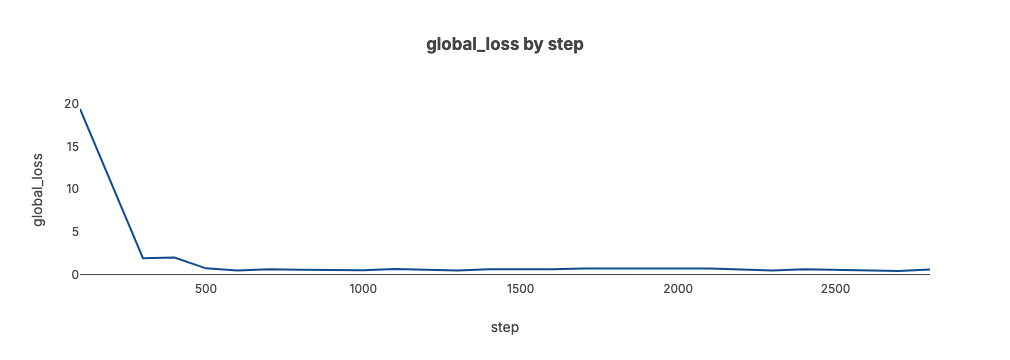

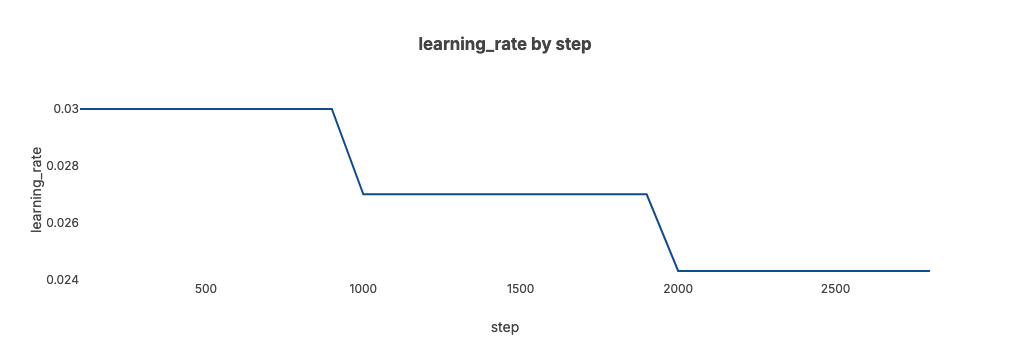

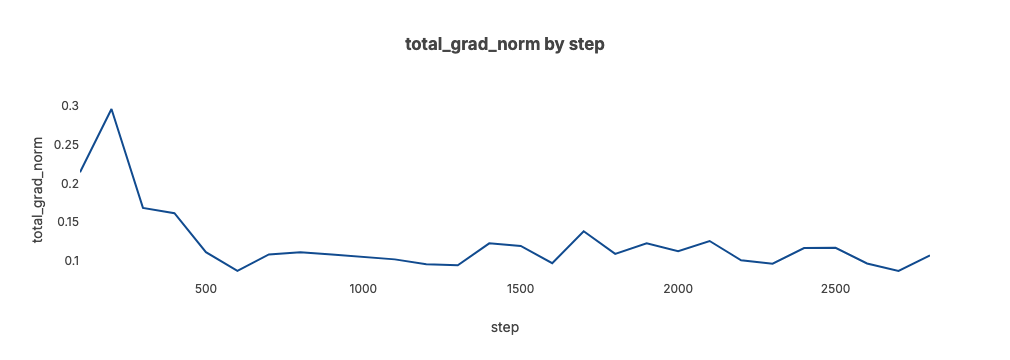

In [22]:
from src.eval import plot_metric, plot_train_vs_val_loss

plot_metric(step_metrics_df, col='global_loss')
plot_metric(step_metrics_df, col='learning_rate')
plot_metric(step_metrics_df, col='total_grad_norm')

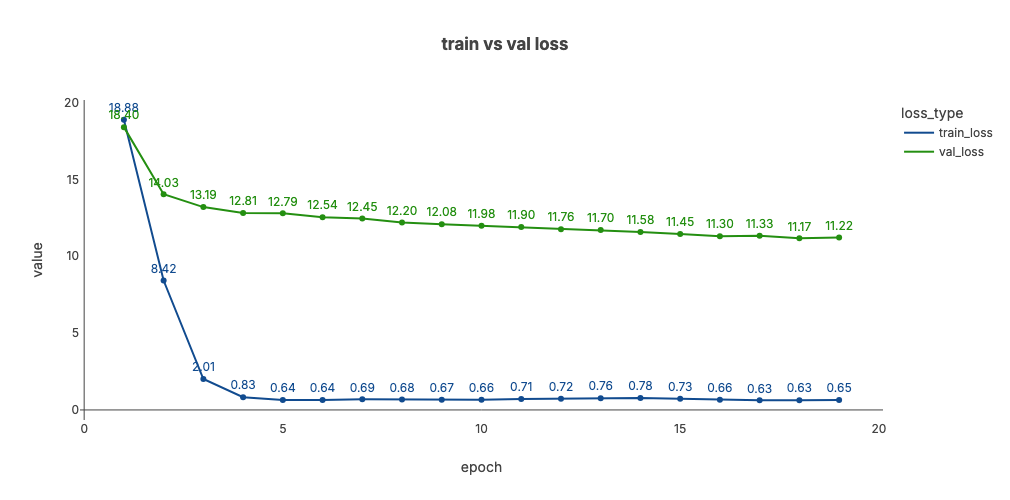

In [23]:
plot_train_vs_val_loss(epoch_metrics_df, height=500)

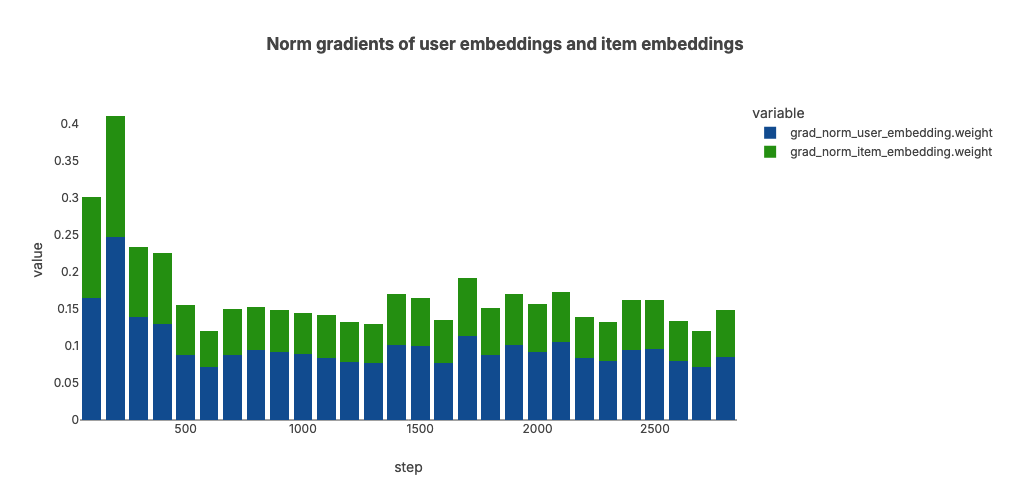

In [24]:
fig = px.bar(
    step_metrics_df,
    x='step',
    y=['grad_norm_user_embedding.weight', 'grad_norm_item_embedding.weight'],
    title='Norm gradients of user embeddings and item embeddings',
    height=500
)
fig.update_layout(showlegend=True, barmode='stack')
fig.show()

# Predict

In [25]:
train_df

,user_id,parent_asin,rating,timestamp
1,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B0863MT183,4.0,1613701986538
2,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B08P8P7686,5.0,1613702112995
3,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B0B7LV3DN2,4.0,1617641445475
4,AEVPPTMG43C6GWSR7I2UGRQN7WFQ,B09WMQ6DXG,5.0,1620231368468
70,AHV6QCNBJNSGLATP56JAWJ3C4G2A,B019WRM1IA,5.0,1451860309000
...,...,...,...,...
735704,AHS2PQ33BWQLXC5NNUZS2BFXD34Q,B07TZT67KX,5.0,1622844181866
735800,AFO5SNKILFVJMSJJ2E3BRLDGE4NA,B09T5VN7D1,4.0,1601154352542
735801,AFO5SNKILFVJMSJJ2E3BRLDGE4NA,B09918MSTF,5.0,1602615880364
736772,AEFPHMM7CLX4UJNXJFQF4ZF5GNAA,B07P27XFP7,5.0,1599585146628


In [26]:
user_id = 'AEHW2B54HDLZ3APBEWXHYLZ6SSYQ'
val_df.loc[lambda df: df['user_id'].eq(user_id)]

,user_id,parent_asin,rating,timestamp
34367,AEHW2B54HDLZ3APBEWXHYLZ6SSYQ,B07MYVF61Y,4.0,1654225907045


In [27]:
item_id = 'B07MYVF61Y'
user_indice = idm.get_user_index(user_id)
item_indice = idm.get_item_index(item_id)

model.predict([user_indice], [item_indice])

tensor([3.4304], grad_fn=<SumBackward1>)